# TreeRBM usage example for binary data

Import dependences

In [2]:
#if os.getenv('CLUSTERBM') != None:
#    os.chdir(os.getenv('CLUSTERBM'))
#sys.path.append(os.getcwd() + '/src')
#sys.path.append(os.getcwd() + '/src/tools')
import os
os.chdir("../")
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot
import json
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
import pandas as pd
from pathlib import Path
from ete3 import Tree

from treerbm.tools.tools_binary import iterate_mean_field, profile_hiddens, profile_visibles
import treerbm.tools.tools_binary as module
from treerbm.treeRBM import fit, generate_tree
from treerbm.ioRBM import get_epochs, get_params
from treerbm.dataset import DatasetRBM
from treerbm.branch_metrics import l2_dist

## Load the model

In [3]:
fname_data = 'example_data/HGD/HGD.dat'
fname_model = 'example_models/2023.11.23.22.28-dna-1000.h5'
fname_ann = 'example_data/HGD/HGD_ann.csv'
fname_col = 'example_data/HGD/HGD_colors.csv'

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Visualize data and TAP fixed points on the PCA

In [5]:
data = torch.tensor(np.loadtxt(fname_data), device=device, dtype=torch.float32)
_, _, Vt = torch.linalg.svd(data - data.mean(0))
data_proj = data @ Vt.mT

In [6]:
f_model = h5py.File(fname_model, "r+")
checkpoints = get_epochs(fname_model)
# load the most trained model
checkpoint = checkpoints[-1]
params = get_params(filename=fname_model, stamp=checkpoint, device=device)

Coollapse the data on the TAP free energy fixed points

In [7]:
mh = profile_hiddens(v=data, hbias=params[1], weight_matrix=params[2])
mv = profile_visibles(h=mh, vbias=params[0], weight_matrix=params[2])

fp = iterate_mean_field(
    X=(mv, mh),
    params=params,
    order=2,
    batch_size=10000,
    device=device
)[0]

# Project the fixed points along the PCA directions
fp_proj = fp @ Vt.mT

Iterating Mean Field:   0%|----------| 0/1 [00:00<?, ?it/s]

Iterating Mean Field: 100%|##########| 1/1 [00:00<00:00,  1.34it/s]


Import the annotations

In [8]:
df_ann = pd.read_csv(fname_ann)
df_ann.head()

,Name,Continent,Population
0,0,European,CEU
1,1,South Asian,STU
2,2,American,CLM
3,3,African,GWD
4,4,American,CLM


Import the file with the colors

In [9]:
df_col = pd.read_csv(fname_col)
df_col.head()

,Label,Color,Legend
0,European,#0094FF,Continent
1,South Asian,#009A00,Continent
2,East Asian,#C43CC8,Continent
3,American,#D03A24,Continent
4,African,#A89400,Continent


Visualize the data and the fixed points with a different color based on the population

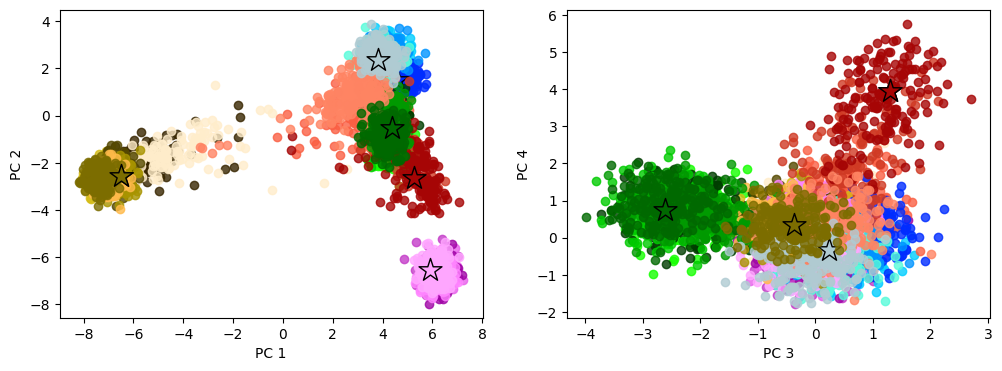

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=100)

ax[0].set_xlabel("PC 1")
ax[0].set_ylabel("PC 2")
ax[1].set_xlabel("PC 3")
ax[1].set_ylabel("PC 4")

for lab in np.unique(df_ann["Population"]):
    idxs = np.where(lab == df_ann["Population"])[0]
    color = df_col[df_col["Label"] == lab]["Color"]
    ax[0].scatter(data_proj[idxs, 0].cpu().numpy(), data_proj[idxs, 1].cpu().numpy(), c=color, alpha=0.8)
    ax[0].scatter(fp_proj[idxs[0], 0].cpu().numpy(), fp_proj[idxs[0], 1].cpu().numpy(), c=color, edgecolor="black", marker="*", s=300)
    ax[1].scatter(data_proj[idxs, 2].cpu().numpy(), data_proj[idxs, 3].cpu().numpy(), c=color, alpha=0.8)
    ax[1].scatter(fp_proj[idxs[0], 2].cpu().numpy(), fp_proj[idxs[0], 3].cpu().numpy(), c=color, edgecolor="black", marker="*", s=300)

## Tree construction

In [11]:
# Output directory
output_dir = "trees/HGD"
output_dir = Path(output_dir)
output_dir.mkdir(exist_ok=True)

# Load the data
dataset = DatasetRBM(data_path=fname_data, ann_path=fname_ann, colors_path=fname_col)
data_type = torch.float32

# Set a maximum number of leafs to put in the tree
n_data = 500
data = torch.tensor(dataset.data[:n_data], device=device).type(data_type)
leaves_names = dataset.names[:n_data]
labels_dict = [{n : l for n, l in dl.items() if n in leaves_names} for dl in dataset.labels]

# Load the checkpoints
t_ages = get_epochs(fname_model)

Fit the treeRBM model

In [12]:
tree_codes, node_features_dict = fit(
        module=module,
        fname=fname_model,
        data=data,
        batch_size=500,
        t_ages=t_ages,
        num_states=2,
        eps=1.,
        alpha=1e-4,
        max_iter=10000,
        order=2,
        filter_ages=False,
        device=device
        )

Generate and save the tree

In [13]:
generate_tree(
        tree_codes=tree_codes,
        leaves_names=leaves_names,
        legend=dataset.legend,
        folder=output_dir,
        labels_dict=labels_dict,
        colors_dict=dataset.colors,
        depth=min(50, tree_codes.shape[1]),
        node_features_dict=node_features_dict,
        dist_fn=l2_dist
    )

Simple visualization of the resulting tree

In [14]:
tree_file = str(output_dir / 'tree.nw')
tree = Tree(tree_file, format=1)
tree.show()

The tree can be visualized by uploading the tree.nw file and the annotations in the website https://itol.embl.de/